# 제목 : 서울특별시 내 버스 및 5100번의 시간별 승하차량 조사

# (1) 주제 선정 이유
제가 서울특별시에서부터 학교까지 통학하고 있기 때문에, 서울특별시 내의 대중교통과 관련해서 조사하고, 데이터를 정리하고 싶었습니다.  
먼저, 통학하면서 어느 시간대에 버스 교통량이 가장 많은지와 어느 정류장에서 가장 많이 막히는지가 궁금해져 이를 조사해야겠다는 생각이 들었고, 서울특별시 내의 전반적인 버스들과 광역버스인 5100번 버스의 데이터를 정리하여, 사람들이 많이 타고 다니는 버스 및 버스 교통 혼잡도를 정리하기 위해 이 주제를 선정했습니다.

# (2) 가설 정의
### 가설 1 : 5100번 버스는 출근시간과 등교시간이 겹치는 7시에서 9시 사이 시간대에 승하차량이 가장 많을 것이다.  
### 가설 2 : 서울 시내 버스의 데이터를 정류장별로 1시간 간격으로 데이터를 정리한다면, 출근시간 7시부터 9시 사이 혹은 퇴근시간인 18시부터 20시 사이에 가장 많은 승하차량이 나타날 것이다.

# (3) 인터넷을 통한 데이터 획득

1. 서울 열린데이터 광장에서 서울특별시 버스노선별 정류장별 시간대별 승하차 인원 정보의 2024년의 3월 공공데이터를 csv 파일로 다운 받았습니다. https://data.seoul.go.kr/dataList/OA-12913/S/1/datasetView.do
2. 경기도교통정보센터에서 2024년 3월 5100번의 시간별 버스 이용객수 통계를 엑셀 파일로 다운 받았습니다.
https://gits.gg.go.kr/gtdb/web/trafficDb/publicTransport/passengersByRoute.do

# (4) 분석을 위한 데이터 가공

분석을 위해 총 6개의 클래스와 메소드들을 만들었다. 각각의 클래스들의 내용은 다음과 같다.

---
1. sort_pandas 클래스는 불필요한 데이터들에 대한 행을 삭제하고, 필요한 데이터들만 남아있는 형태를 불러온다. 
2. sort_pandas 클래스의 derived class들인 TotalBusGraph, Time_by_station_Graph와 Most_Passengers_graph_by_station 클래스들을 만들었다.  
3. TotalBusGraph 특정 노선번호에 해당하는 정류장들의 시간대별 승하차량의 모든 데이터들에 접근하고, 각각의 시간대별에 승하차량이 가장 많은 값을 리스트에 저장하여 이를 나타내는 데이터에 접근한다.  
4. Time_by_station_Graph는 TotalBusGraph에서 특정 정류장의 시간대별 데이터에 접근하여, 그 값들을 리스트에 저장한다.  
5. Most_Passengers_graph_by_station내의 메소드는 특정 노선번호의 정류장별 승하차량의 최댓값과 승하차량이 최대일 때의 시간대에 대한 데이터에 접근하여, 그 값들을 리스트에 저장한다.
6. fileRead 클래스는 csv파일을 open으로 열어 필요한 데이터들만 선별하여, 그것들을 리스트로 만들어 반환한다.
7. fileRead 클래스의 derived class인 Data_5100 클래스는 fileRead를 통해 정리된 5100번의 데이터에서 시간별 승하차량 데이터에 접근한다.  
---
위의 클래스들로 가설을 확인할 수 있는 데이터들에 접근해, 그래프로 알 수 있게 나타내줄 것이다.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import csv
import warnings
# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings(action = 'ignore')

# file_name으로 받은 데이터를 가공하는 클래스
class sort_pandas:
    
    result_dataFrame = []
    
    def __init__(self, file_name):
        self.file_name = file_name
        
    def readfile(self):
        result_dataFrame = pd.read_csv(self.file_name, sep = ',', encoding = 'cp949')
        return result_dataFrame
    
    def bus_num_sortfile(self, bus_number):
        filt_bus_number = (self.readfile()['노선번호'] == bus_number)
        return self.readfile()[filt_bus_number]
    
    def bus_num_and_station_sortfile(self, bus_number):
        data = self.bus_num_sortfile(bus_number)
        station_num = data['역명'].str.slice(-6, -1)
        data['정류장 번호'] = station_num
        result_dataFrame = data.sort_values('정류장 번호')
        return result_dataFrame
    
    def dataFile_colRemove(self, bus_number):
        removeCol = ['노선명', '표준버스정류장ID', '버스정류장ARS번호','교통수단타입명', '등록일자', '정류장 번호']
        data = self.bus_num_and_station_sortfile(bus_number)
        result_dataFrame = data.drop(columns = removeCol)
        return result_dataFrame
    
class TotalBusGraph(sort_pandas):
    
    hours = [f'{hour}시' for hour in range(24)]

    def __init__(self, file_name, bus_number):
        super().__init__(file_name)
        self.bus_number = bus_number
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)
                
    def getTotalBusGraph(self, bus_number):
        matplotlib.rcParams['font.size'] = 10
        if(bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다.")
        else:
            #데이터 선별
            data_list = []
            data_fix = self.dataFile_colRemove(bus_number)
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index']).T
            for i in range(result_data.shape[0]):
                data_list.append(result_data.iloc[i])

            # 시간별 데이터에서 최댓값과 그에 해당하는 정류장 저장
            max_value_list = []
            station_name_list = []
            for List in data_list[1:]:
                max_value = 0
                station_name = ""
                for i in range(len(List)):
                    if(max_value < int(List[i])):
                        max_value = int(List[i])
                        station_name = data_list[0][i]
                max_value_list.append(max_value)
                station_name_list.append(station_name)
            
            # 꺾은선 그래프 그리기
            fig, ax1 = plt.subplots(figsize = (22, 12))
            ax2 = ax1.twinx()
            lns1 = ax1.plot(self.hours, data_list[1:], label = data_list[0], ls = '-.')
            lns2 = ax2.plot(self.hours, max_value_list, marker = 'o', mfc = '#a0c4ff')
            lns = lns1 + lns2
            labs = [l.get_label() for l in lns]
            ax1.legend(lns, labs ,ncol = 5, bbox_to_anchor = (0.5, -0.15), loc = 'upper center')

            for j in range(len(max_value_list)):
                ax2.annotate(f'{station_name_list[j]}\n{max_value_list[j]}명', xy = (self.hours[j], max_value_list[j]), 
                textcoords = 'offset points', xytext = (0,10), ha = 'center')
    
            ax1.grid()
            ax1.set_xlabel('시간')
            ax1.set_ylabel('승객 수')
            ax1.set_title(f'{bus_number}번 버스 교통량 그래프')
    
            ax2.set_ylabel('승객 수')
            return plt.show()


class Time_by_station_Graph(sort_pandas):

    hours = [f'{hour}시' for hour in range(24)]
    
    def __init__(self, file_name, bus_number):
        super().__init__(file_name)
        self.bus_number = bus_number
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)
        
    def get_Time_by_station_Graph(self, index_number):
        # 데이터 선별
        if(self.bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다")
        else:
            data_fix = self.dataFile_colRemove(self.bus_number)
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index']).T

            # y값 선별
            y_axis_data = []
            for i in range(1, result_data.shape[0]):
                y_axis_data.append(result_data.iloc[i][index_number])

            bus_station = result_data.iloc[0][index_number]
            colors = [
                "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF", "#FFB3BA",
                "#FFC0CB", "#FFD700", "#B0E0E6", "#F5DEB3", "#E6E6FA", "#D3D3D3",
                "#FFB6C1", "#F08080", "#E0FFFF", "#FAFAD2", "#D8BFD8", "#DDA0DD",
                "#B0C4DE", "#ADD8E6", "#98FB98", "#FF69B4", "#F4A460", "#D2B48C"
            ]

            # 데이터 레이블 표현
            matplotlib.rcParams['font.size'] = 10
            bar = plt.bar(self.hours, y_axis_data, color = colors)
            for idx,rect in enumerate(bar):
                plt.text(idx, rect.get_height() + 1, y_axis_data[idx], ha = 'center')
            plt.title(f'{self.bus_number}번의 {bus_station} 시간별 데이터')
            plt.xlabel('시간')
            plt.ylabel('이용객 수')
            plt.xticks(rotation = 90)
            return plt.show()

class Most_Passengers_graph_by_station(sort_pandas):
    
    hours = [f'{hour}시' for hour in range(24)]

    def __init__(self, file_name, bus_number):
        super().__init__(file_name)
        self.bus_number = bus_number
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)

    def get_Most_Passengers_graph_by_station(self, bus_number):
        if(bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다.")
        else:
            # 데이터 선별
            data_list = []
            data_fix = self.dataFile_colRemove(bus_number)
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index'])
            for i in range(result_data.shape[0]):
                data_list.append(result_data.iloc[i])

            # 정류장별로 최댓값 추출과 그 당시의 시간대 추출
            max_value_list = []
            hour_list = []
            for List in data_list:
                max_value = 0
                station_name = ''
                for i in range(1, len(List)):
                    if(max_value < int(List[i])):
                        max_value = int(List[i])
                        hour = self.hours[i]
                max_value_list.append(max_value)
                hour_list.append(hour)

            # 정류장 분할
            division_of_data_num1 = (len(max_value_list) // 3)
            division_of_data_num2 = 2 * division_of_data_num1

            # 그래프 그리기
            plt.figure(figsize = (22, 40))
            matplotlib.rcParams['font.size'] = 18

            plt.subplot(311)
            plt.plot(result_data['역명'][:division_of_data_num1], max_value_list[:division_of_data_num1], marker = 'v')
    
            for j in range(division_of_data_num1):
                plt.annotate(f'{hour_list[j]}\n{max_value_list[j]}명', xy = (result_data['역명'][j], max_value_list[j]),
                        textcoords = 'offset points', xytext = (0, 10), ha = 'center')
            
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.subplot(312)
            plt.plot(result_data['역명'][division_of_data_num1:division_of_data_num2],
                max_value_list[division_of_data_num1:division_of_data_num2], marker = 'X')
    
            for k in range(division_of_data_num1, division_of_data_num2):
                plt.annotate(f'{hour_list[k]}\n{max_value_list[k]}명', xy = (result_data['역명'][k], max_value_list[k]),
                    textcoords = 'offset points', xytext = (0, 10), ha = 'center')
                      
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.subplot(313)
            plt.plot(result_data['역명'][division_of_data_num2:], max_value_list[division_of_data_num2:], marker = '*')
    
            for l in range(division_of_data_num2, len(max_value_list)):
                plt.annotate(f'{hour_list[l]}\n{max_value_list[l]}명', xy = (result_data['역명'][l], max_value_list[l]),
                    textcoords = 'offset points', xytext = (0, 10), ha = 'center')
                      
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.tight_layout()
            return plt.show()
        
#file_name을 받아서, 받은 파일의 데이터의 일부를 list로 반환하는 클래스
class fileRead:

    def __init__(self, file_name):
        self.file_name = file_name

    def file_open(self):
        data = list()
        file = open(self.file_name, 'r', encoding = 'utf-8')
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
        file.close()
        return data
    
    def data_correct(self):
        data_correct2 = []
        data_correct1 = self.file_open()[1:]
        for i in range(len(data_correct1)):
            data_correct2.append([data_correct1[i][6], data_correct1[i][13:]])
        return data_correct2        
        
class Data_5100(fileRead):

    def __init__(self, file_name):
        super().__init__(file_name)

    def get_5100_graph(self):
        # 데이터 가공
        data_5100 = self.data_correct()
        data_5100_list = data_5100[2:]

        # x값 데이터와 y값 데이터 추출
        x_axis_data = []
        y_axis_data = []
        for i in range(len(data_5100_list)):
            data_5100_list[i][0] = data_5100_list[i][0][0:3]
            x_axis_data.append(data_5100_list[i][0])
            y_axis_data.append(int(data_5100_list[i][1][2]))

        # y값의 최댓값 구하기
        max_value = 0
        for item in y_axis_data:
            if(max_value <= item):
                max_value = item

        # 그래프 그리기
        matplotlib.rcParams['font.size'] = 10
        colors = ['#ffadad' if item != max_value else '#9bf6ff' for item in y_axis_data]
        bar = plt.bar(x_axis_data, y_axis_data, color = colors)

        for idx, rect in enumerate(bar):
            plt.text(idx, rect.get_height() + 1, y_axis_data[idx], ha = 'center')
        plt.title('5100번 버스 3월 승하차량 데이터')
        plt.xlabel('시간')
        plt.ylabel('승객 수')
        plt.xticks(rotation = 90)
        return plt.show()

# (5) 분석 결과 도출

각 그래프별 결과의 의미는 다음과 같다.  

---
1. 특정 노선번호가 다니는 모든 정류장의 시간대별 승하차량 데이터들을 그래프로 나타냈고, 각 시간대별로 승하차량이 최대인 정류장과 그 정류장의 승하차량을 나타내주는 그래프이다.  
2. 1번의 그래프에서 특정 노선번호가 다니는 정류장 중 특정 정류장에 대한 데이터에 접근하는 것이 어렵기에, 특정 정류장의 시간별 데이터를 나타내주는 그래프이다. 인덱스 번호는 1번의 그래프의 범례를 통해 확인할 수 있다.
3. 2번의 그래프를 통해, 각각의 정류장에서 승하차량이 많은 시간대와 그 시간대의 승하차량을 일일이 접근하기 어렵기에, 특정 노선번호가 다니는 정류장의 승하차량의 최댓값과 시간대를 나타내주는 그래프이다.
4. 광역버스인 5100번의 시간대별 승하차량을 나타내주는 그래프이다.
---

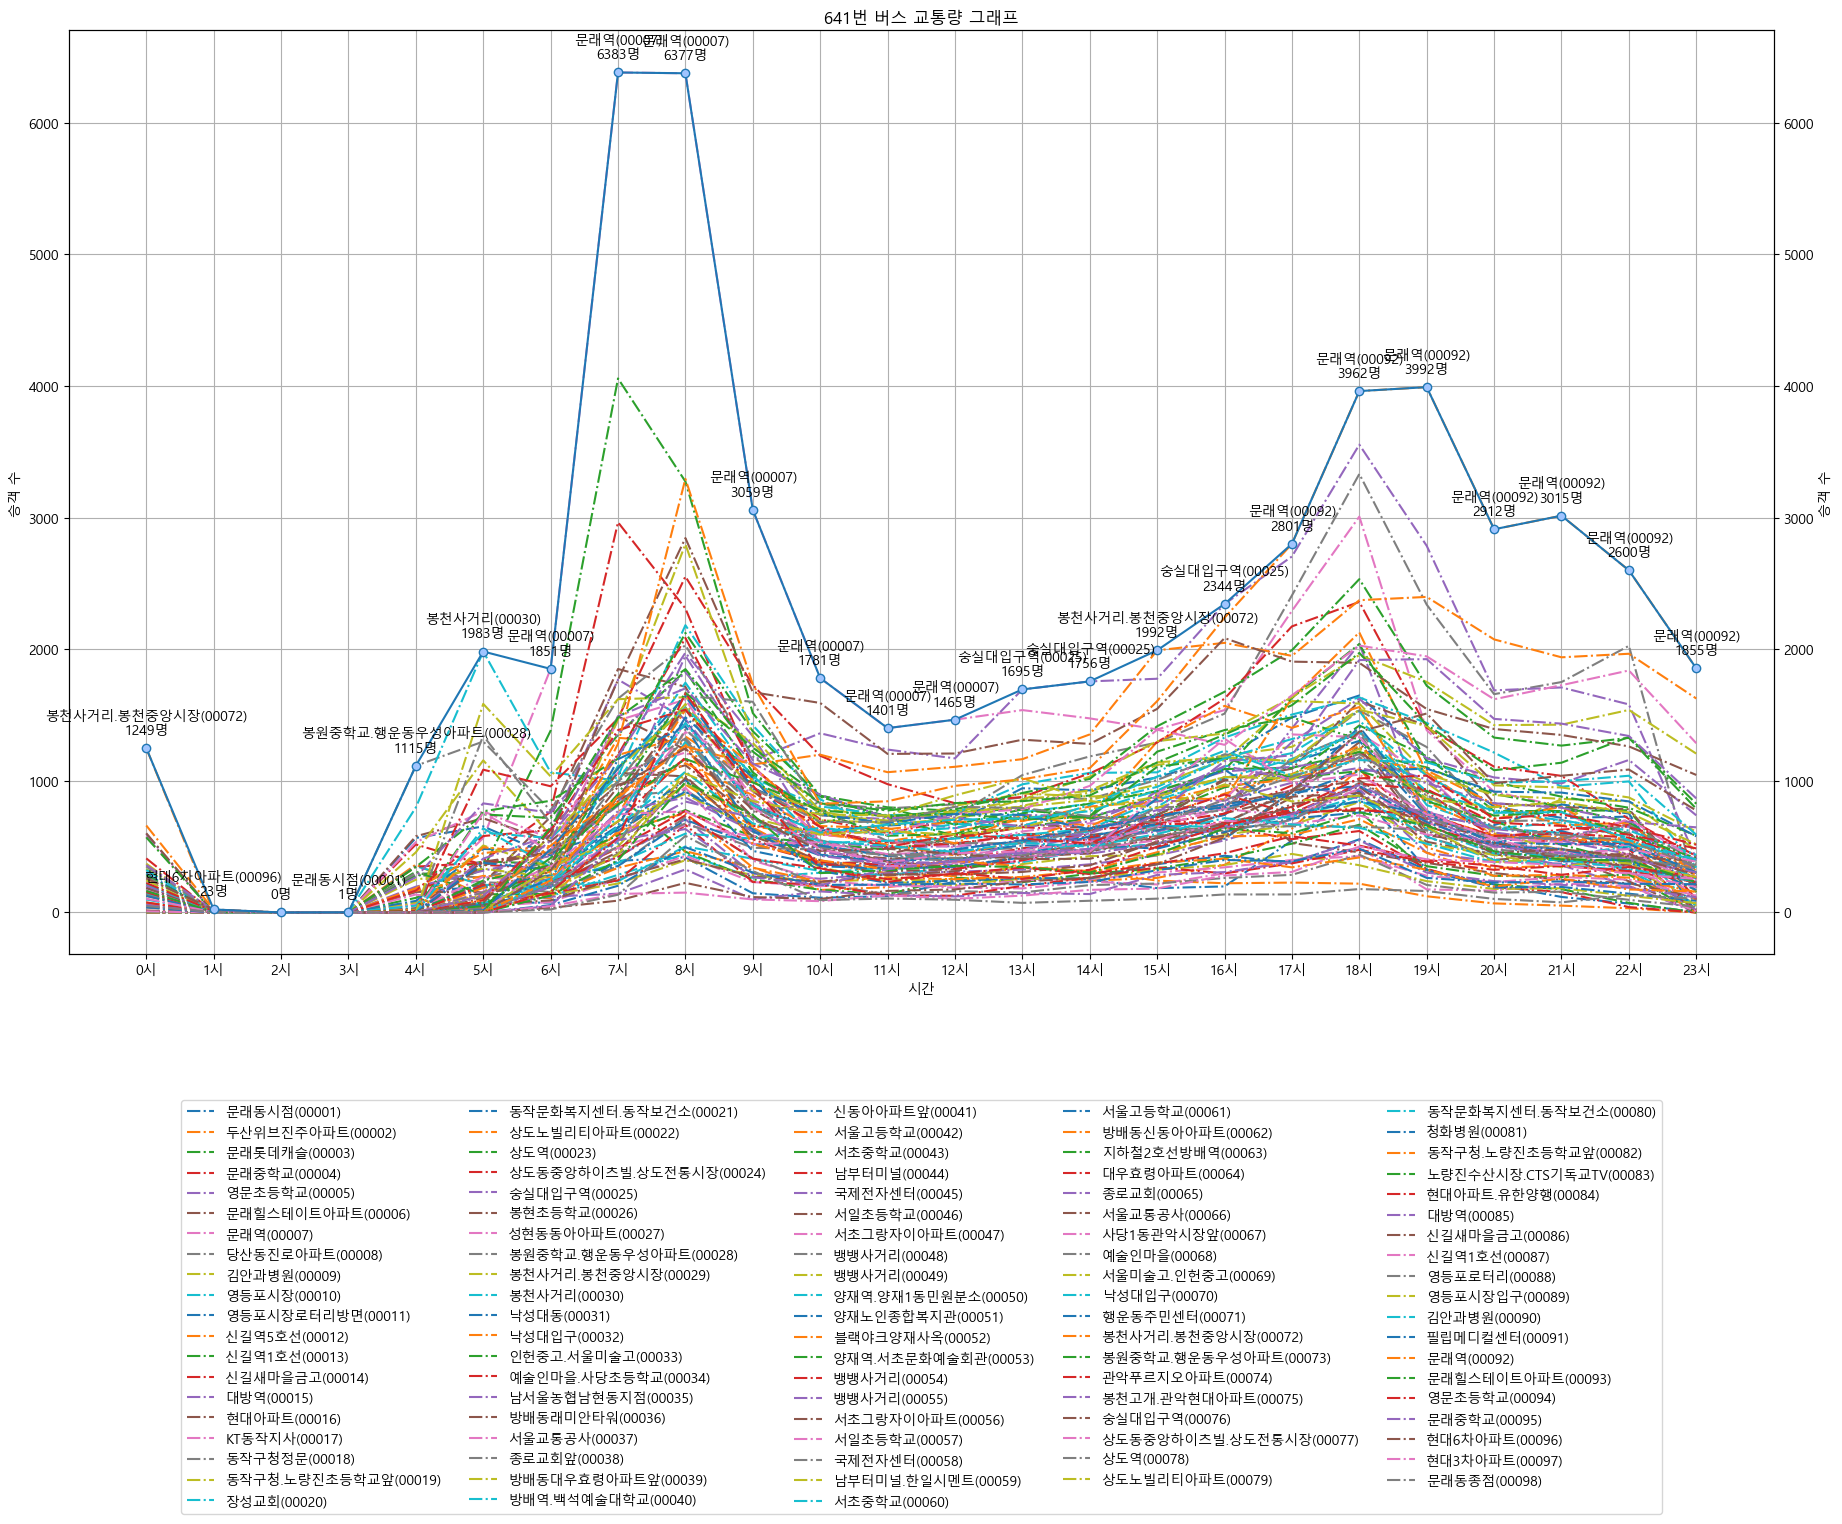

In [2]:
userInput_bus_number = input('버스의 노선번호를 입력해주세요 : ')
tbg = TotalBusGraph('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
tbg.getTotalBusGraph(userInput_bus_number)

In [5]:
userInput_index_number = int(input("정류장의 인덱스 번호를 입력해주세요 : "))
tbsg = Time_by_station_Graph('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
tbsg.get_Time_by_station_Graph(userInput_index_number)

정류장의 인덱스 번호를 입력해주세요 : 1
해당하는 노선번호가 없습니다


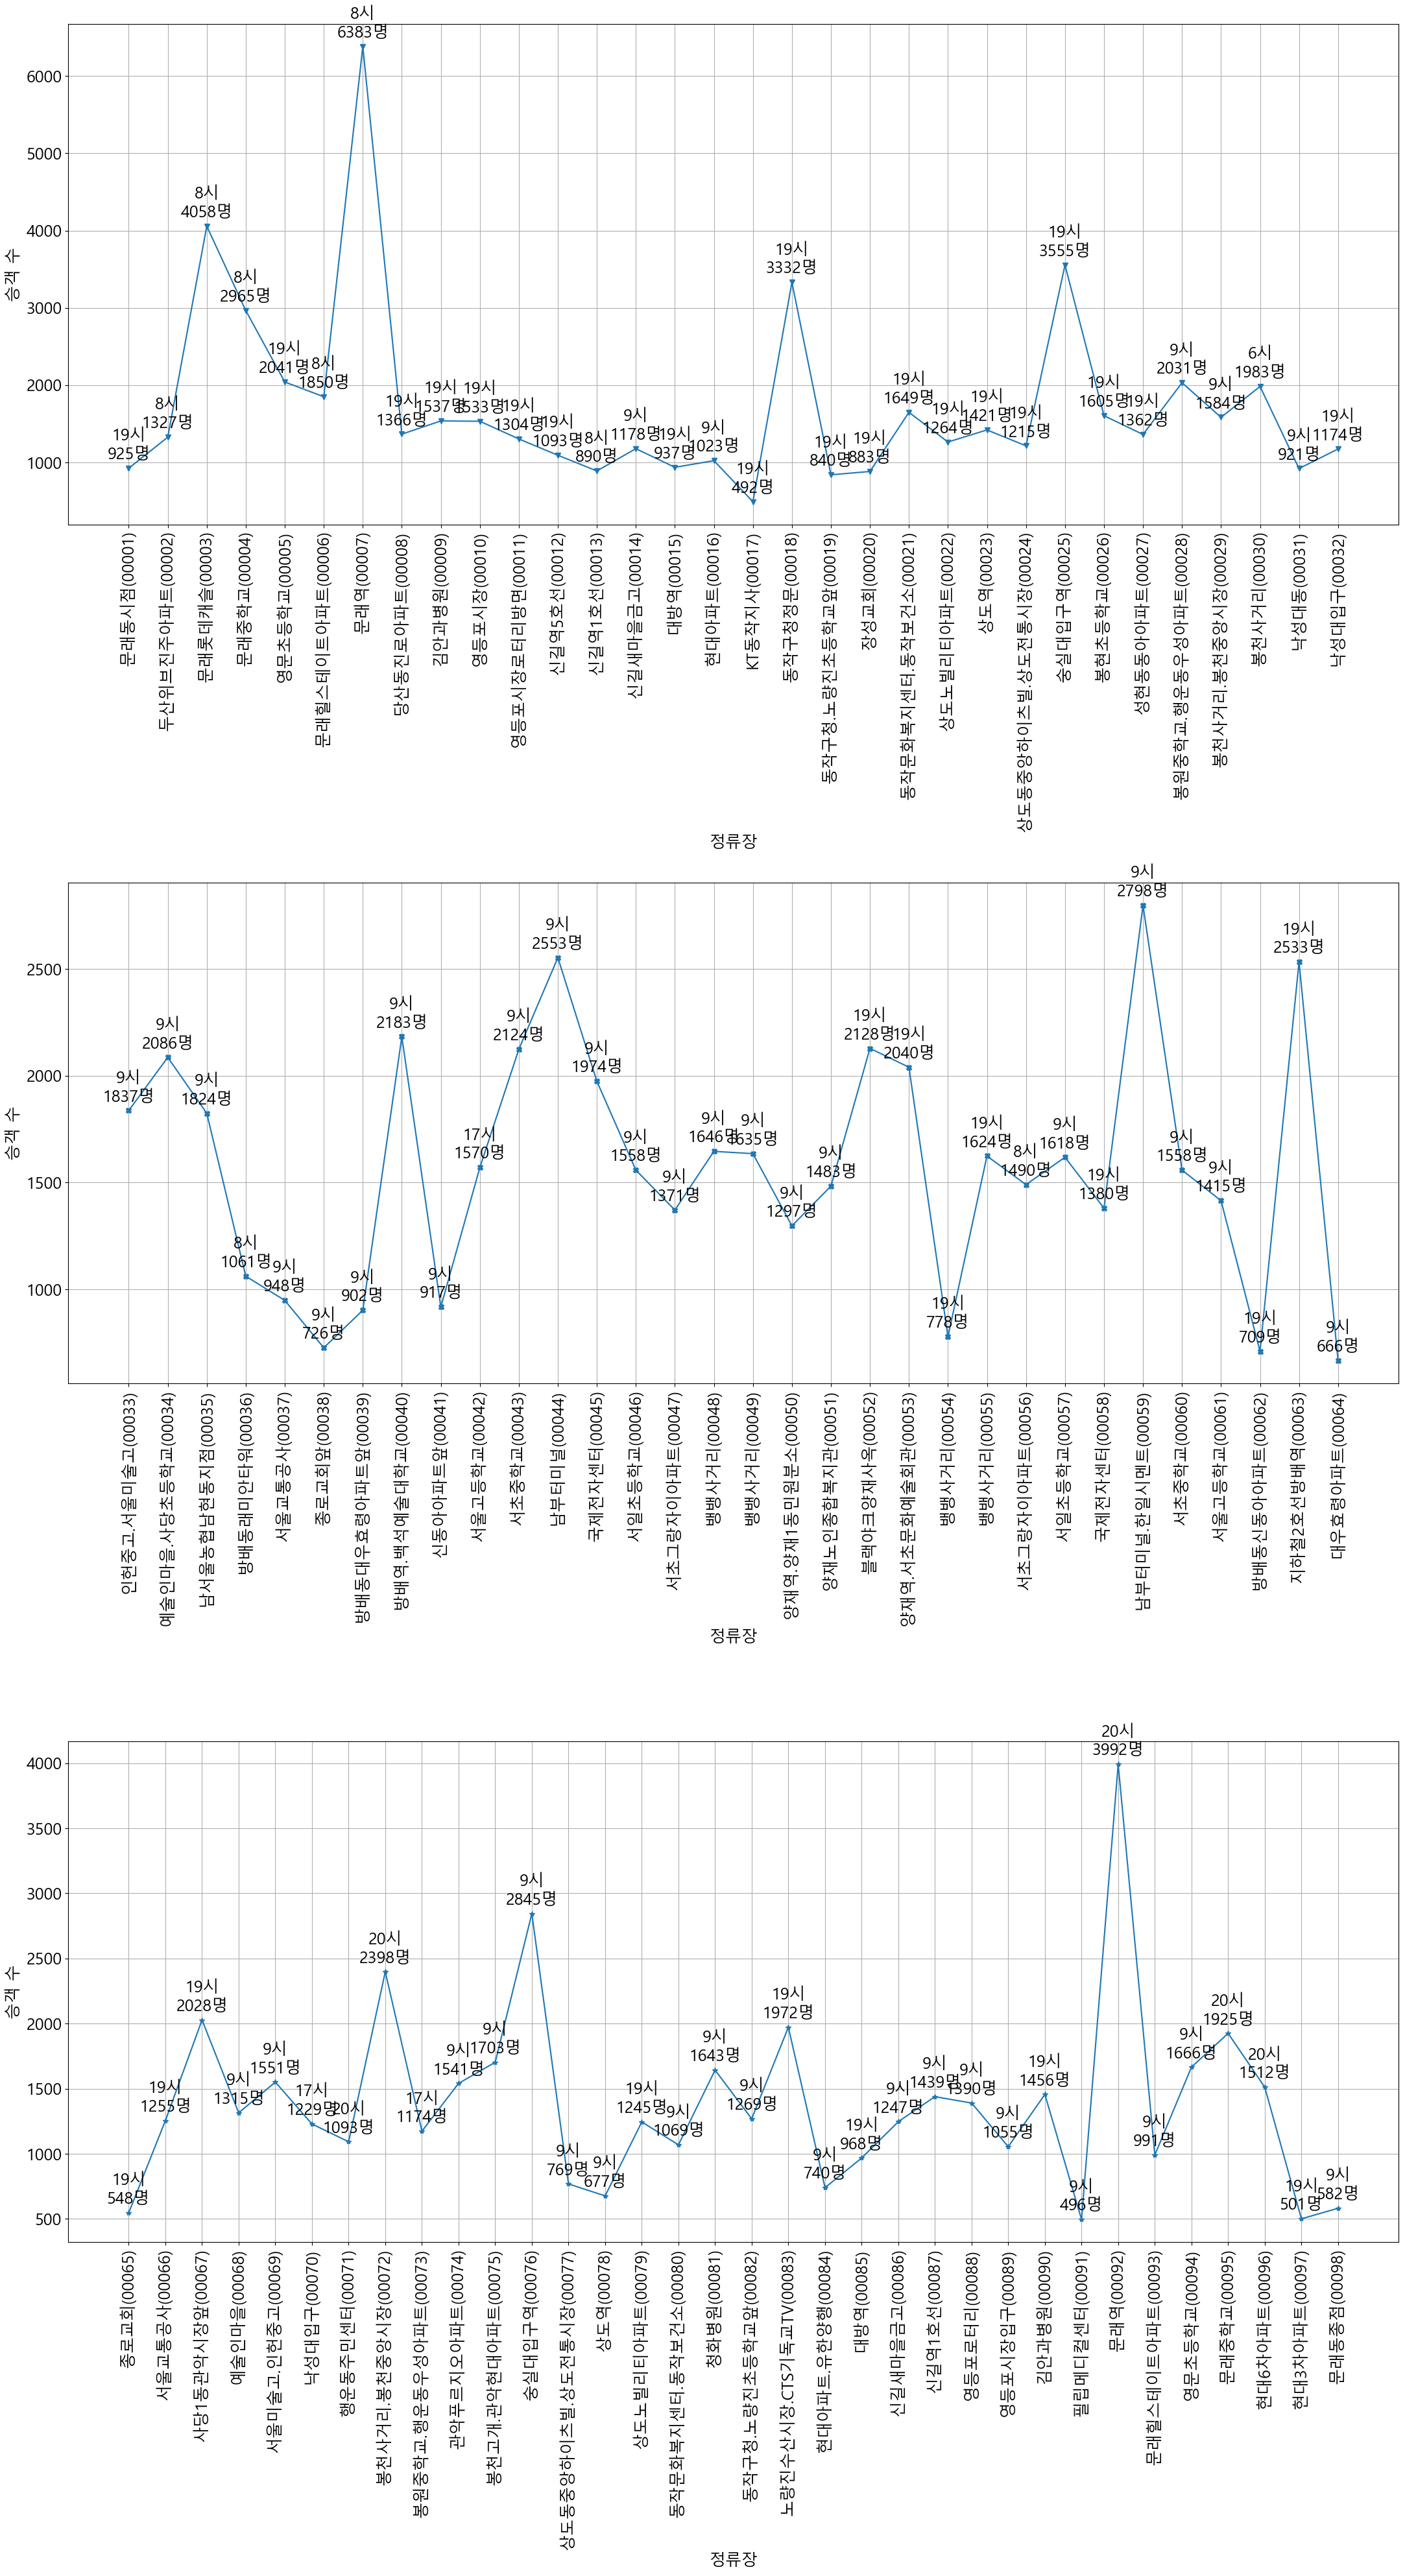

In [4]:
userInput_bus_number = input("버스의 노선번호를 입력해주세요 : ")
mpgbs = Most_Passengers_graph_by_station('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
mpgbs.get_Most_Passengers_graph_by_station(userInput_bus_number)

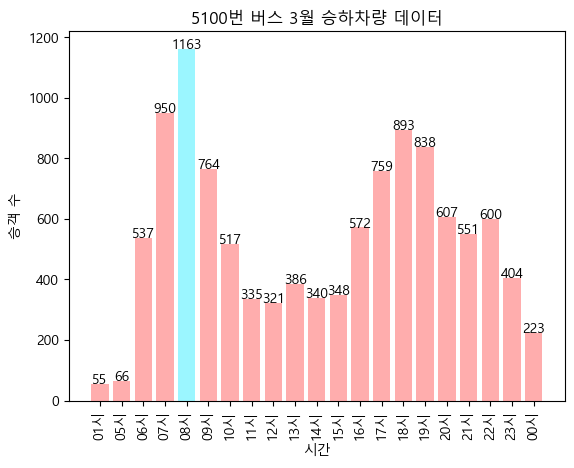

In [15]:
num_5100_data = Data_5100('5100_bus_2024_03.csv')
num_5100_data.get_5100_graph()

# (6) 결론

1. 그래프를 확인해보면, 5100번 버스는 8시부터 9시 사이가 승하차량이 가장 많았고, 그 다음으로 7시에서 8시 사이가 승하차량이 많았다. 이를 통해, 첫번째 가설이 들어맞음을 알 수 있다.  
2. 서울 시내버스 중 하나인 641번 버스를 비롯해 여러 버스의 첫번째 그래프를 확인해보면, 승하차량이 가장 많은 시간대는 출근시간대인 7시와 9시 사이 혹은 퇴근 시간대인 18시와 20시 사이에 승하차량이 가장 많은 것으로 나타났다.<br> 하지만, 위의 버스들의 세번째 그래프를 통해, 승하차량을 확인해보면, 모든 정류장이 출근시간대 혹은 퇴근시간대에 가장 많은 승하차량을 보여주는 것은 아니다. <br> 따라서, 2번째 가설을 일반화하기보다는 대체로 출근시간과 퇴근시간에 승하차량이 가장 많다로 결론을 내리는 것이 바람직하다.

# (7) 참고문헌

1. 서울 열린데이터 광장 - 서울시 버스노선별 정류장별 시간대별 승하차 인원 정보 - 3월 데이터파일 https://data.seoul.go.kr/dataList/OA-12913/S/1/datasetView.do  
2. 경기도교통정보센터 - 노선별 버스 이용객수 - 5100번 3월 엑셀 파일 https://gits.gg.go.kr/gtdb/web/trafficDb/publicTransport/passengersByRoute.do  
3. 파이썬 코딩 무료 강의(활용편5) - 데이터 분석 및 시각화, 이 영상 하나로 끝내세요 https://www.youtube.com/watch?v=PjhlUzp_cU0
4. 1분 파이썬 -(46)파일입출력 https://www.youtube.com/watch?v=2JQ24B3OVZU
5. 블로그 - [pandas] 문자열 데이터 다루기 https://zephyrus1111.tistory.com/221
6. 블로그 - Python csv를 list로 반환 https://jspark33.tistory.com/63
7. 블로그 - [Python] 데이터프레임 행/열 바꾸기 : Transpose, T https://mizykk.tistory.com/132
8. 블로그 - Matplotlib에서 플롯 영역 밖에 범례 위치하기 https://docs.kanaries.net/ko/topics/Matplotlib/matplotlib-legend-outside-of-plot
9. 블로그 - [pandas] warning 메세지 출력 안하기 https://soundprovider.tistory.com/entry/pandas-warning-%EB%A9%94%EC%84%B8%EC%A7%80-%EC%B6%9C%EB%A0%A5-%EC%95%88%ED%95%98%EA%B8%B0  
10. 블로그 - [파이썬 시각화]꺾은선 그래프(Line Chart) https://blog.naver.com/breezehome50/222297546136
11. 블로그 - plt.annotate를 이용한 python 그래프 꾸미기와 설정 방법 https://lifelong-education-dr-kim.tistory.com/entry/pltannotate%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-python-%EA%B7%B8%EB%9E%98%ED%94%84-%EA%BE%B8%EB%AF%B8%EA%B8%B0%EC%99%80-%EC%84%A4%EC%A0%95-%EB%B0%A9%EB%B2%95  
12. 블로그 - [Matplotlib Tip]1. subplot 겹치지 않게 하기 https://zephyrus1111.tistory.com/120
13. 블로그 - [Markdown] Juypter Notebook :: 주피터 노트북 마크다운 정리 https://leedakyeong.tistory.com/entry/Markdown-Jupyter-Notebook-%EC%A3%BC%ED%94%BC%ED%84%B0-%EB%85%B8%ED%8A%B8%EB%B6%81-%EB%A7%88%ED%81%AC%EB%8B%A4%EC%9A%B4-%EC%A0%95%EB%A6%AC  

# (8) 별첨 : (3)의 획득한 데이터 원본

Seoul_bus_2024_03.csv 파일과 5100_bus_2024_03.xlsx 파일이다.
(압축파일에 같이 첨부)

# (9) 별첨 : (4)의 가공된 데이터 원본

 Seoul_bus_2024_03_fix.csv 파일과 5100_bus_2024_03.csv 파일이다.
 (압축파일에 같이 첨부)

# (10) 별첨 : (3)을 (4)로 변환하는 등의 작업을 위하여 본인이 직접 개발한 Python 소스코드 원본

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import csv
import warnings
# 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
warnings.filterwarnings(action = 'ignore')

# file_name으로 받은 데이터를 가공하는 클래스
class sort_pandas:
    
    result_dataFrame = []
    
    def __init__(self, file_name, bus_number):
        self.file_name = file_name
        self.bus_number = bus_number
        
    def readfile(self):
        result_dataFrame = pd.read_csv(self.file_name, sep = ',', encoding = 'cp949')
        return result_dataFrame
    
    def bus_num_sortfile(self):
        filt_bus_number = (self.readfile()['노선번호'] == self.bus_number)
        return self.readfile()[filt_bus_number]
    
    def bus_num_and_station_sortfile(self):
        data = self.bus_num_sortfile()
        station_num = data['역명'].str.slice(-6, -1)
        data['정류장 번호'] = station_num
        result_dataFrame = data.sort_values('정류장 번호')
        return result_dataFrame
    
    def dataFile_colRemove(self):
        removeCol = ['노선명', '표준버스정류장ID', '버스정류장ARS번호','교통수단타입명', '등록일자', '정류장 번호']
        data = self.bus_num_and_station_sortfile()
        result_dataFrame = data.drop(columns = removeCol)
        return result_dataFrame
    
class TotalBusGraph(sort_pandas):
    
    hours = [f'{hour}시' for hour in range(24)]

    def __init__(self, file_name, bus_number):
        super().__init__(file_name, bus_number)
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)
                
    def getTotalBusGraph(self, bus_number):
        matplotlib.rcParams['font.size'] = 10
        if(bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다.")
        else:
            #데이터 선별
            data_list = []
            data_fix = self.dataFile_colRemove()
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index']).T
            for i in range(result_data.shape[0]):
                data_list.append(result_data.iloc[i])

            # 시간별 데이터에서 최댓값과 그에 해당하는 정류장 저장
            max_value_list = []
            station_name_list = []
            for List in data_list[1:]:
                max_value = 0
                station_name = ""
                for i in range(len(List)):
                    if(max_value < int(List[i])):
                        max_value = int(List[i])
                        station_name = data_list[0][i]
                max_value_list.append(max_value)
                station_name_list.append(station_name)
            
            # 꺾은선 그래프 그리기
            fig, ax1 = plt.subplots(figsize = (22, 12))
            ax2 = ax1.twinx()
            lns1 = ax1.plot(self.hours, data_list[1:], label = data_list[0], ls = '-.')
            lns2 = ax2.plot(self.hours, max_value_list, marker = 'o', mfc = '#a0c4ff')
            lns = lns1 + lns2
            labs = [l.get_label() for l in lns]
            ax1.legend(lns, labs ,ncol = 5, bbox_to_anchor = (0.5, -0.15), loc = 'upper center')

            for j in range(len(max_value_list)):
                ax2.annotate(f'{station_name_list[j]}\n{max_value_list[j]}명', xy = (self.hours[j], max_value_list[j]), 
                textcoords = 'offset points', xytext = (0,10), ha = 'center')
    
            ax1.grid()
            ax1.set_xlabel('시간')
            ax1.set_ylabel('승객 수')
            ax1.set_title(f'{bus_number}번 버스 교통량 그래프')
    
            ax2.set_ylabel('승객 수')
            return plt.show()


class Time_by_station_Graph(sort_pandas):

    hours = [f'{hour}시' for hour in range(24)]
    
    def __init__(self, file_name, bus_number):
        super().__init__(file_name, bus_number)
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)
        
    def get_Time_by_station_Graph(self, index_number):
        # 데이터 선별
        if(self.bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다")
        else:
            data_fix = self.dataFile_colRemove()
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index']).T

            # y값 선별
            y_axis_data = []
            for i in range(1, result_data.shape[0]):
                y_axis_data.append(result_data.iloc[i][index_number])

            bus_station = result_data.iloc[0][index_number]
            colors = [
                "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9", "#BAE1FF", "#FFB3BA",
                "#FFC0CB", "#FFD700", "#B0E0E6", "#F5DEB3", "#E6E6FA", "#D3D3D3",
                "#FFB6C1", "#F08080", "#E0FFFF", "#FAFAD2", "#D8BFD8", "#DDA0DD",
                "#B0C4DE", "#ADD8E6", "#98FB98", "#FF69B4", "#F4A460", "#D2B48C"
            ]

            # 데이터 레이블 표현
            matplotlib.rcParams['font.size'] = 10
            bar = plt.bar(self.hours, y_axis_data, color = colors)
            for idx,rect in enumerate(bar):
                plt.text(idx, rect.get_height() + 1, y_axis_data[idx], ha = 'center')
            plt.title(f'{self.bus_number}번의 {bus_station} 시간별 데이터')
            plt.xlabel('시간')
            plt.ylabel('이용객 수')
            plt.xticks(rotation = 90)
            return plt.show()

class Most_Passengers_graph_by_station(sort_pandas):
    
    hours = [f'{hour}시' for hour in range(24)]

    def __init__(self, file_name, bus_number):
        super().__init__(file_name, bus_number)
        self.bus_number_list = []
        df = self.readfile()['노선번호']
        for item in df:
            if(item not in self.bus_number_list):
                self.bus_number_list.append(item)

    def get_Most_Passengers_graph_by_station(self, bus_number):
        if(bus_number not in self.bus_number_list):
            print("해당하는 노선번호가 없습니다.")
        else:
            # 데이터 선별
            data_list = []
            data_fix = self.dataFile_colRemove()
            Data = data_fix[data_fix.columns[2:77:3]]
            Data.reset_index(inplace = True)
            result_data = Data.drop(columns = ['index'])
            for i in range(result_data.shape[0]):
                data_list.append(result_data.iloc[i])

            # 정류장별로 최댓값 추출과 그 당시의 시간대 추출
            max_value_list = []
            hour_list = []
            for List in data_list:
                max_value = 0
                station_name = ''
                for i in range(1, len(List)):
                    if(max_value < int(List[i])):
                        max_value = int(List[i])
                        hour = self.hours[i]
                max_value_list.append(max_value)
                hour_list.append(hour)

            # 정류장 분할
            division_of_data_num1 = (len(max_value_list) // 3)
            division_of_data_num2 = 2 * division_of_data_num1

            # 그래프 그리기
            plt.figure(figsize = (22, 40))
            matplotlib.rcParams['font.size'] = 18

            plt.subplot(311)
            plt.plot(result_data['역명'][:division_of_data_num1], max_value_list[:division_of_data_num1], marker = 'v')
    
            for j in range(division_of_data_num1):
                plt.annotate(f'{hour_list[j]}\n{max_value_list[j]}명', xy = (result_data['역명'][j], max_value_list[j]),
                        textcoords = 'offset points', xytext = (0, 10), ha = 'center')
            
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.subplot(312)
            plt.plot(result_data['역명'][division_of_data_num1:division_of_data_num2],
                max_value_list[division_of_data_num1:division_of_data_num2], marker = 'X')
    
            for k in range(division_of_data_num1, division_of_data_num2):
                plt.annotate(f'{hour_list[k]}\n{max_value_list[k]}명', xy = (result_data['역명'][k], max_value_list[k]),
                    textcoords = 'offset points', xytext = (0, 10), ha = 'center')
                      
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.subplot(313)
            plt.plot(result_data['역명'][division_of_data_num2:], max_value_list[division_of_data_num2:], marker = '*')
    
            for l in range(division_of_data_num2, len(max_value_list)):
                plt.annotate(f'{hour_list[l]}\n{max_value_list[l]}명', xy = (result_data['역명'][l], max_value_list[l]),
                    textcoords = 'offset points', xytext = (0, 10), ha = 'center')
                      
            plt.xlabel('정류장')
            plt.ylabel('승객 수')
            plt.xticks(rotation = 90)
            plt.grid()
    
            plt.tight_layout()
            return plt.show()
        
#file_name을 받아서, 받은 파일의 데이터의 일부를 list로 반환하는 클래스
class fileRead:

    def __init__(self, file_name):
        self.file_name = file_name

    def file_open(self):
        data = list()
        file = open(self.file_name, 'r', encoding = 'utf-8')
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
        file.close()
        return data
    
    def data_correct(self):
        data_correct2 = []
        data_correct1 = self.file_open()[1:]
        for i in range(len(data_correct1)):
            data_correct2.append([data_correct1[i][6], data_correct1[i][13:]])
        return data_correct2        
        
class Data_5100(fileRead):

    def __init__(self, file_name):
        super().__init__(file_name)

    def get_5100_graph(self):
        # 데이터 가공
        data_5100 = self.data_correct()
        data_5100_list = data_5100[2:]

        # x값 데이터와 y값 데이터 추출
        x_axis_data = []
        y_axis_data = []
        for i in range(len(data_5100_list)):
            data_5100_list[i][0] = data_5100_list[i][0][0:3]
            x_axis_data.append(data_5100_list[i][0])
            y_axis_data.append(int(data_5100_list[i][1][2]))

        # y값의 최댓값 구하기
        max_value = 0
        for item in y_axis_data:
            if(max_value <= item):
                max_value = item

        # 그래프 그리기
        matplotlib.rcParams['font.size'] = 10
        colors = ['#ffadad' if item != max_value else '#9bf6ff' for item in y_axis_data]
        bar = plt.bar(x_axis_data, y_axis_data, color = colors)

        for idx, rect in enumerate(bar):
            plt.text(idx, rect.get_height() + 1, y_axis_data[idx], ha = 'center')
        plt.title('5100번 버스 3월 승하차량 데이터')
        plt.xlabel('시간')
        plt.ylabel('승객 수')
        plt.xticks(rotation = 90)
        return plt.show()
    
userInput_bus_number = input('버스의 노선번호를 입력해주세요 : ')
tbg = TotalBusGraph('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
tbg.getTotalBusGraph(userInput_bus_number)

userInput_index_number = int(input("정류장의 인덱스 번호를 입력해주세요 : "))
tbsg = Time_by_station_Graph('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
tbsg.get_Time_by_station_Graph(userInput_index_number)

userInput_bus_number = input("버스의 노선번호를 입력해주세요 : ")
mpgbs = Most_Passengers_graph_by_station('Seoul_bus_2024_03_fix.csv', userInput_bus_number)
mpgbs.get_Most_Passengers_graph_by_station(userInput_bus_number)

num_5100_data = Data_5100('5100_bus_2024_03.csv')
num_5100_data.get_5100_graph()